In [1]:
from modsim import *

%matplotlib inline

In [ ]:
rabbit_sys = System(t0 = 0, 
                t_end = 20,
                adult_pop0 = 10,
                juvenile_pop0 = 0,
                
                birth_rate = 0.9,
                death_rate = 0.5,
                mature_rate = 0.33)

In [ ]:
def run_rabbit_simulation(system):
    """Runs a proportional growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: System object with t0, t_end, p0,
            birth_rate and death_rate
    """
    adults = TimeSeries()
    adults[system.t0] = system.adult_pop0
    juveniles = TimeSeries()
    juveniles[system.t0] = system.juvenile_pop0
    
    for t in linrange(system.t0, system.t_end):
        births = system.birth_rate * adults[t]
        deaths = system.death_rate * adults[t]
        maturations = system.mature_rate * juveniles[t]
        
        juveniles[t+1] = juveniles[t] + births - deaths
        adults[t+1] = adults[t] + maturations - deaths
        
        
    system.adults = adults
    system.juveniles = juveniles

In [ ]:
def plot_rabbit_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot(system.adults, 'bo-', label='adults')
    plot(system.juveniles, 'ro-', label='juveniles')
    decorate(xlabel='Season', 
             ylabel='Rabbit population',
             title=title)

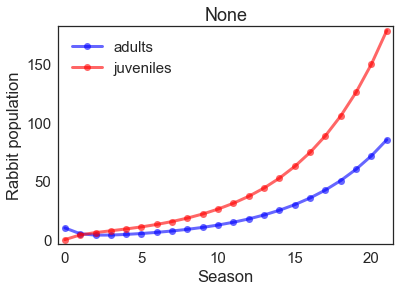

In [53]:
run_rabbit_simulation(rabbit_sys)
plot_rabbit_results(rabbit_sys)

In [73]:
def make_system(beta, gamma, total, infected):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=(total - infected), I=infected, R=0)
    init /= sum(init)
    
    pop0 = sum(init)
    
    
    
    t0 = 0
    t_end = 100

    return System(init=init, t0=t0, pop0=pop0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [152]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

#defines beta and gamma for make_system

In [160]:
sir.beta

0.3

In [161]:
sir = make_system(0.3, 0.25)
sir.pop1

90

In [51]:
def update1(state, system):

    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered 
    r += recovered 

    
    return State(S=s, I=i, R=r)

In [47]:
sir.S

0      99.000000
1     100.670000
2     103.985421
3     109.193518
4     116.707667
5     127.218145
6     141.905091
7     162.885027
8     194.244453
9     244.750432
10    336.241072
11    536.354005
dtype: float64

In [78]:
def run_SIR_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()
    S_pop = TimeSeries()
    I_pop = TimeSeries()
    R_pop = TimeSeries()

    state = system.init
    #init to winit
    t0 = system.t0
    S[t0], I[t0], R[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        
        state = update_func(state, system)
        S[t+1], I[t+1], R[t+1] = state
    
    S_pop = S * system.pop0
    I_pop = I * system.pop0
    R_pop = R * system.pop0
    system.S = S_pop
    system.I = I_pop
    system.R = R_pop
    

In [179]:
run_SIR_simulation(sir, update1)


In [4]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [195]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)
run_SIR_simulation(sir, update1)


TypeError: make_system() missing 2 required positional arguments: 'total' and 'infected'

In [193]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma, 100, 1)
#run_SIR_simulation(sir, update1)
update1(sir.init, sir)
#plot_results(sir.S, sir.I, sir.R)


0.98999999999999999

In [76]:
def run_SIR_simulation(system, disease_func):
    """More attempt to change things, as I am starting to think it will be necessary to plug a separate
    update function into the loop that deals with actual population numbers, then merge the two numbers somehow.
    Actually that could maybe be done inside the loop too, where you have for t in linrange: update percentaages,
    now apply new percentages to new poulation and/or vice versa, now do the same thing for the next t. This
    would pobably make the bit at the end that applies the percentage to the total population redundant.
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()
    S_pop = TimeSeries()
    I_pop = TimeSeries()
    R_pop = TimeSeries()
    total_pop = TimeSeries()
    

    state = system.init
    #init to winit
    t0 = system.t0
    S[t0], I[t0], R[t0] = state
    S_pop[0] = S[0] * system.pop0
    I_pop[0] = I[0] * system.pop0
    R_pop[0] = R[0] * system.pop0
    total_pop[0] = system.pop0
    
    for t in linrange(system.t0, system.t_end):
        total_pop[t] = S_pop[t] + I_pop[t] + R_pop[t]
        births = system.birth_rate * total_pop[t]
        deaths = system.death_rate * total_pop[t]
        state = disease_func(state, system)
        S[t+1], I[t+1], R[t+1] = state
        
    
    S_pop = S * system.pop0
    I_pop = I * system.pop0
    R_pop = R * system.pop0
    system.S = S_pop
    system.I = I_pop
    system.R = R_pop
    

In [77]:
tc = 0.5      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma, 100, 5)
run_SIR_simulation(sir, disease_spread1)
plot_results(sir.S, sir.I, sir.R)

KeyError: 1

In [25]:
sir.S

0    99.000000
1    96.670000
2    94.966455
3    93.911831
4    93.535009
5    93.877154
6    94.998949
dtype: float64